In [1]:
from config import *
from utils import *

import os
import pickle
import collections
import numpy as np

# Suppress pandas future warning, which messes tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import scipy
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import (r2_score, precision_score, recall_score, precision_recall_curve, average_precision_score,
                            f1_score, matthews_corrcoef, mean_absolute_error,
                            median_absolute_error, mean_squared_error,
                             roc_auc_score, roc_curve, auc)

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import subprocess

In [2]:
# Consider only repair genotypes with at least COUNT_THRES observed transcripts for computing PSI values.
COUNT_THRES = 50

In [3]:
indel_splice_precas_count_map = load_bc_seq(INDEL_SPLICE_PRECAS_COUNT_MAP)
indel_splice_postcas_count_map = load_bc_seq(INDEL_SPLICE_POSTCAS_COUNT_MAP)
gt_splice_count_map = load_bc_seq(GT_SPLICE_COUNT_MAP)
gt_precas_splice_count_map = load_bc_seq(GT_PRECAS_SPLICE_COUNT_MAP)
predicted_gt_indel_dist_map = load_var(PREDICTED_GT_INDEL_DIST_MAP)

# Empirical Exon B Retention Frequencies ($\Psi_R$, $\Psi_G$, and WT $\Psi$)
Pseudo count of 1:
$\Psi = \frac{T_B + 1}{T_B + T_C + 2}$

In [4]:
PSEUDO_COUNT = 1

def get_B_retention_f(indel_splice_count_map):
    result = []
    total_counts = []
    for indel, splice_count_map in indel_iterator(indel_splice_count_map):
        if not (indel[1] == 'N' or indel[1] in DELETION_SIGNATURES or (indel[1] in INSERTION_SIGNATURES and indel[2] == 1)):
            continue
            
        C_f = (splice_count_map['C'] + PSEUDO_COUNT) / (splice_count_map['C'] + splice_count_map['B'] + 2*PSEUDO_COUNT)
        result.append(1 - C_f)
        total_counts.append(splice_count_map['C'] + splice_count_map['B'])
    return result, total_counts


def get_aggBf_scores(gt_splice_count_map):
    aggBf_scores = []
    aggBf_counts = []
    for gt in gt_splice_count_map.keys():
        m = gt_splice_count_map[gt]
        C_f = (m['C'] + PSEUDO_COUNT) / (m['C'] + m['B'] + 2*PSEUDO_COUNT)
        aggBf_scores.append(1 - C_f)
        aggBf_counts.append(m['C'] + m['B'])
    return aggBf_scores, aggBf_counts

In [5]:
splice_precas_Bf, splice_precas_total = get_B_retention_f(indel_splice_precas_count_map)
splice_postcas_Bf, splice_postcas_total = get_B_retention_f(indel_splice_postcas_count_map)
aggBf_scores, aggBf_counts = get_aggBf_scores(gt_splice_count_map)

# Load MMSplice and SpliceAI Predictions on dat-B and inDelphi predictions

In [6]:
mmsplice_precas_df = pd.read_csv(MMSPLICE_PRECAS_DF_PATH)
mmsplice_postcas_df = pd.read_csv(MMSPLICE_POSTCAS_DF_PATH)

In [7]:
# Generates indels x predictions matrix
def mmsplice_df_to_scores_df(df, indel_splice_count_map, progress=True):
    indel_splice_count_map_list = list(indel_iterator(indel_splice_count_map))
    scores = []
    iterator = tqdm(range(len(indel_splice_count_map_list))) if progress else range(len(indel_splice_count_map_list))

    for i in iterator:
        p = df[df['gene_id'] == 'g' + str(i)]
        indel = indel_splice_count_map_list[i][0]
        if indel[1] == 'N' or indel[1] in DELETION_SIGNATURES or (indel[1] in INSERTION_SIGNATURES and indel[2] == 1):
            exon_b_preds = p[p['exon_id'] == 'e' + str(i) + 'BC'].iloc[0]
            scores.append(exon_b_preds[[
                'alt_acceptorIntron',
                'alt_acceptor',
                'alt_exon'
            ]].values)
    return np.array(scores)

In [8]:
X_mmsplice_postcas = mmsplice_df_to_scores_df(mmsplice_postcas_df, indel_splice_postcas_count_map, True)
X_mmsplice_precas = mmsplice_df_to_scores_df(mmsplice_precas_df, indel_splice_precas_count_map, True)

In [9]:
print(X_mmsplice_precas.shape, X_mmsplice_postcas.shape)

(1697, 3) (17350, 3)


In [10]:
with open(SPLICEAI_PRECAS_PREDS_PATH, 'rb') as f:
    spliceai_precas_preds = np.load(f)
with open(SPLICEAI_POSTCAS_PREDS_PATH, 'rb') as f:
    spliceai_postcas_preds = np.load(f)

In [11]:
X_spliceai_postcas = logit(np.max(spliceai_postcas_preds[:, :, 1], axis=1).reshape(-1, 1))
X_spliceai_precas = logit(np.max(spliceai_precas_preds[:, :, 1], axis=1).reshape(-1, 1))

In [12]:
print(X_spliceai_precas.shape, X_spliceai_postcas.shape)

(1697, 1) (17350, 1)


In [13]:
X_precas = np.hstack([X_mmsplice_precas, X_spliceai_precas])
X_postcas = np.hstack([X_mmsplice_postcas, X_spliceai_postcas])

In [14]:
print(X_precas.shape, X_postcas.shape)

(1697, 4) (17350, 4)


In [15]:
class SplicePredsData:
    def __init__(self, X, Bf, counts, indel_splice_count_map,
                 columns, count_thres=COUNT_THRES):
        self.X = X
        self.Bf = np.array(Bf)
        self.counts = np.array(counts)
        self.indel_splice_count_map = indel_splice_count_map
        self.count_thres = count_thres
        self.columns = columns
        
        self.aggBf = np.array(aggBf_scores)
        self.aggBf_counts = np.array(aggBf_counts)
        
        self._process()
        
    def _process(self):
        indel_splice_count_map_list = list(indel_iterator(self.indel_splice_count_map))
        
        # Remove skipping frequencies calculated from low data support
        self.Bf = self.Bf[self.counts > self.count_thres]
        self.X = self.X[self.counts > self.count_thres, :]
        self.gids = np.array([count_map['gid'] for indel, count_map in indel_splice_count_map_list])
        self.gids = self.gids[self.counts > self.count_thres]
        self.indels = [indel_splice_count_map_list[i][0] for i, c in enumerate(self.counts) if c > self.count_thres]
        self.counts = self.counts[self.counts > self.count_thres]
        
        self.X_df = pd.DataFrame({ col: list(self.X[:, i]) for i, col in enumerate(self.columns) })
        self.y = np.array(list(logit(self.Bf)))
        
    def plot_actual_vs_pred(self, column, normal=False):
        x = expit(self.X_df[column]) if normal else self.X_df[column]
        y = expit(self.y) if normal else self.y
        g = sns.jointplot(x, y,
                        height=5, kind="reg",
                        joint_kws = {'scatter_kws':dict(alpha=0.3)}).annotate(scipy.stats.pearsonr)
        g.set_axis_labels("Predicted logit($\Psi_R$)", "Actual logit($\Psi_R$)", fontsize=12)
        
        if normal:
            limx, limy = 0, 1
            g.ax_joint.set_xlim((limx, limy))
            g.ax_joint.set_ylim((limx, limy))
        
        
        x0, x1 = g.ax_joint.get_xlim()
        y0, y1 = g.ax_joint.get_ylim()
        lims = [max(x0, y0), min(x1, y1)]
        g.ax_joint.plot(lims, lims, color='black', linestyle='dashed')
        return g
    
    def plot_actual_vs_pred_simple(self, column, method='SpliceAI', fname='spliceai_simple_post.png'):
        x = expit(self.X_df[column])
        y = expit(self.y)
        
        scorers = [("Pearson's R", lambda a,b: scipy.stats.pearsonr(a,b)[0]),
            ("Mean Squared Error", mean_squared_error),
            ("Mean Absolute Error", mean_absolute_error),
            ("Median Absolute Error", median_absolute_error),
            ("RMSE", lambda a,b: np.sqrt(mean_squared_error(a,b)))]
        for sname, scorer in scorers:
            print(sname, scorer(y, x))
        
        
        fig = plt.figure(figsize=(5,5))
        print(scipy.stats.pearsonr(x, y))
        plt.scatter(x, y, alpha=0.3)
        limx, limy = 0, 1
        plt.xlim((limx, limy))
        plt.ylim((limx, limy))
        plt.plot([limx, limy], [limx, limy], color='black', linestyle='dashed')
        plt.title("$\mathbf{" + method + "}$\n" + str(len(x)) + 
                  " Repair Outcomes\nPearson's $r = " +
                  "{:.2f}".format(scipy.stats.pearsonr(x, y)[0], 2) + 
                  ', p = '+"{:.2E}".format(scipy.stats.pearsonr(x, y)[1]) +
                  '$')
        plt.xlabel("Predicted $P$(acceptor) (= $\Psi_R$)", fontsize=12)
        plt.ylabel("Actual $\Psi_R$", fontsize=12)
        plt.axes().set_aspect('equal')
        plt.savefig(os.path.join(IMAGES_DIR, fname), dpi=300, bbox_inches='tight')
        plt.show()

In [16]:
data_spliceai_precas = SplicePredsData(X_spliceai_precas,
                                       splice_precas_Bf,
                                       splice_precas_total,
                                       indel_splice_precas_count_map,
                                       ['spliceaiLogitAcceptor'])
data_spliceai_postcas = SplicePredsData(X_spliceai_postcas,
                                       splice_postcas_Bf,
                                       splice_postcas_total,
                                       indel_splice_postcas_count_map,
                                       ['spliceaiLogitAcceptor'])

In [17]:
data_mmsplice_precas = SplicePredsData(X_mmsplice_precas,
                                       splice_precas_Bf,
                                       splice_precas_total,
                                       indel_splice_precas_count_map,
                                       ['acceptorIntronScore', 'acceptorScore', 'exonScore'])
data_mmsplice_postcas = SplicePredsData(X_mmsplice_postcas,
                                       splice_postcas_Bf,
                                       splice_postcas_total,
                                       indel_splice_postcas_count_map,
                                       ['acceptorIntronScore', 'acceptorScore', 'exonScore'])

In [18]:
data_all_precas = SplicePredsData(X_precas,
                                   splice_precas_Bf,
                                   splice_precas_total,
                                   indel_splice_precas_count_map,
                                   ['acceptorIntronScore', 'acceptorScore', 'exonScore', 'spliceaiLogitAcceptor'])
data_all_postcas = SplicePredsData(X_postcas,
                                   splice_postcas_Bf,
                                   splice_postcas_total,
                                   indel_splice_postcas_count_map,
                                   ['acceptorIntronScore', 'acceptorScore', 'exonScore', 'spliceaiLogitAcceptor'])

## S5 Fig

In [19]:
def beforePSI_vs_afterPSI():
    y_after = []
    gids_after = []
    for i, gt in enumerate(gt_splice_count_map):
        gid = exp_grna_gid_map[gt[0]][0]
        if gid in data_all_postcas.gids:
            gids_after.append(gid)
            y_after.append(aggBf_scores[i])
    
    indel_splice_precas_count_map_list = list(indel_iterator(indel_splice_precas_count_map))
    precas_gid_bf = {count_map['gid']:splice_precas_Bf[i] for i, (indel, count_map) in enumerate(indel_splice_precas_count_map_list)}
    gids = set(gids_after) & precas_gid_bf.keys()
    y_after = [y_after[i] for i, gid in enumerate(gids_after) if gid in gids]
    y_before = [precas_gid_bf[gid] for gid in gids_after if gid in gids]
    print("Number of gRNAs:", len(y_after))
    print("Number of WT PSI < 0.5:", sum(y_before[i] < 0.5 for i in range(len(y_before))))
    print("Min WT PSI:", min(y_before))
    print("Mean WT PSI (pre Cas9):", np.mean(y_before))
    print("Mean PSI_G (post Cas9):", np.mean(y_after))

    g = sns.jointplot(y_before, y_after,xlim=(0,1), ylim=(0,1), kind='scatter', alpha=0.3)
    g.ax_joint.plot([0, 1], [0, 1], color='black', linestyle='dashed') 
    g.set_axis_labels("$\Psi$ WT (before Cas9)", "$\Psi_G$ (after Cas9)", fontsize=16)
    plt.savefig(os.path.join(IMAGES_DIR, 'S_psi_before_after.png'), dpi=300, bbox_inches='tight')
    plt.show()

Number of gRNAs: 735
Number of WT PSI < 0.5: 5
Min WT PSI: 0.4545454545454546
Mean WT PSI (pre Cas9): 0.9091996368346704
Mean PSI_G (post Cas9): 0.6838906075443971


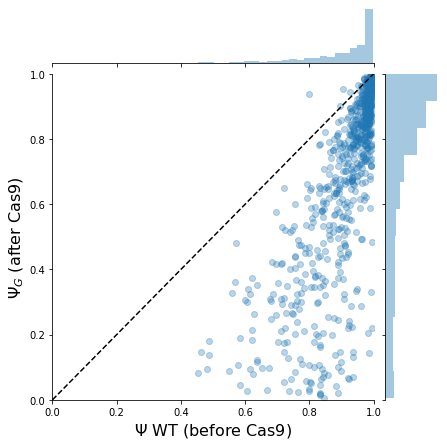

In [20]:
beforePSI_vs_afterPSI()

# MaxEntScan baseline on dat-B

In [21]:
def predict_MESScores(indel_splice_count_map):
    seq_23mers = []
    for indel, splice_count_map in indel_iterator(indel_splice_count_map):
        if not(indel[1] == 'N' or indel[1] in DELETION_SIGNATURES or (indel[1] in INSERTION_SIGNATURES and indel[2] == 1)):
            continue
            
        seq = exp_tid_target_map[exp_gid_tid_map[splice_count_map['gid']]]
        splice_idx = splice_count_map['spliceidx']
        prefix = 'TACCAGCTGCCCTCGTCGAC'
        suffix = 'TGATTACACATATAGACACGC'
        seq = prefix + seq + suffix
        splice_idx += len(prefix)
        if splice_idx < 20:
            seq = 'N' * (splice_idx - 20) + seq
        seq_23mer = seq[splice_idx - 20:splice_idx + 3]
        assert len(seq_23mer) == 23
        seq_23mers.append(seq_23mer)
    with open(os.path.join(MAXENTSCAN_DIR, 'query'), 'w') as f:
        f.write('\n'.join(seq_23mers))
    
    output = subprocess.check_output(
        ['perl', 'score3.pl', 'query'],
        universal_newlines=True,
        cwd=MAXENTSCAN_DIR
    )
    return [float(r.split('\t')[1]) for r in output.strip().split('\n')]

In [22]:
splice_postcas_MESScores = predict_MESScores(indel_splice_postcas_count_map)

In [23]:
splice_precas_MESScores = predict_MESScores(indel_splice_precas_count_map)

In [24]:
def plot_Bf_vs_prediction(bf, scores, count_total):
    bf = np.array(bf)
    scores = np.array(scores)
    count_total = np.array(count_total)
    
    bf = bf[count_total > COUNT_THRES]
    scores = scores[count_total > COUNT_THRES]
    print(len(scores))
    ax = sns.jointplot(scores, bf, kind="reg", 
                       joint_kws = {'scatter_kws':dict(alpha=0.3)}).annotate(scipy.stats.pearsonr, fontsize=12)
    return ax

def plot_Bf_vs_MESScore(bf, scores, count_total):
    ax = plot_Bf_vs_prediction(bf, scores, count_total)
    ax.ax_marg_y.set_ylim(-0.01, 1.01)
    return ax

def plot_Bf_vs_MESScore_simple(bf, scores, count_total):
    bf = np.array(bf)
    scores = np.array(scores)
    count_total = np.array(count_total)
    
    bf = bf[count_total > COUNT_THRES]
    scores = scores[count_total > COUNT_THRES]
    print(len(scores))
    
    fig = plt.figure(figsize=(5,5))
    print(scipy.stats.pearsonr(scores, bf))
    plt.scatter(scores, bf, alpha=0.3)

    plt.title("$\mathbf{MaxEntScan}$\n" + str(len(scores)) + 
              " Repair Outcomes\nPearson's $r = " +
              "{:.2f}".format(scipy.stats.pearsonr(scores, bf)[0], 2) + 
              ', p = '+"{:.2E}".format(scipy.stats.pearsonr(scores, bf)[1]) +
              '$')
    plt.xlabel("MaxEntScan 3' Score", fontsize=12)
    plt.ylabel("Actual $\Psi_R$", fontsize=12)
#     plt.axes().set_aspect('equal')
#     ax.ax_marg_y.set_ylim(-0.01, 1.01)
    plt.ylim([0,1])
    return ax

2113


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


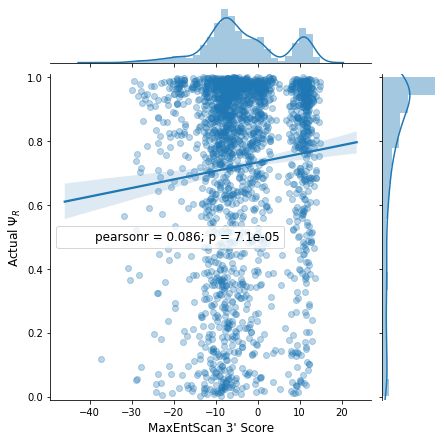

In [25]:
ax = plot_Bf_vs_MESScore(splice_postcas_Bf, splice_postcas_MESScores, splice_postcas_total)
ax.set_axis_labels("MaxEntScan 3' Score", 'Actual $\Psi_R$', fontsize=12)
plt.savefig(os.path.join(IMAGES_DIR, 'maxentscan_post.png'), dpi=300, bbox_inches='tight')
plt.show()

## Fig 3A

2113
(0.08629454292082869, 7.133236892388965e-05)


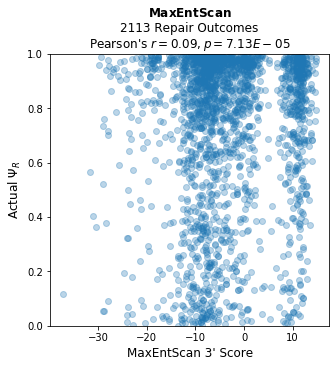

In [26]:
ax = plot_Bf_vs_MESScore_simple(splice_postcas_Bf, splice_postcas_MESScores, splice_postcas_total)
ax.set_axis_labels("MaxEntScan 3' Score", 'Actual $\Psi_R$', fontsize=12)
plt.savefig(os.path.join(IMAGES_DIR, 'maxentscan_simple_post.png'), dpi=300, bbox_inches='tight')
plt.show()

## S4 FigA

1205


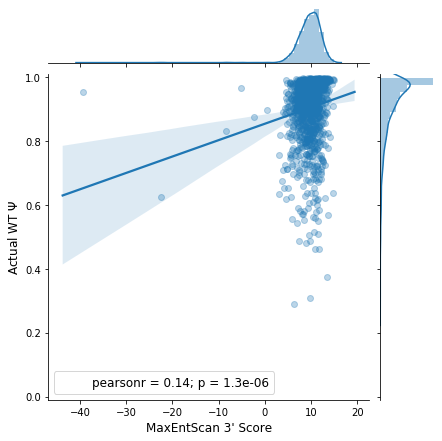

In [27]:
ax = plot_Bf_vs_MESScore(splice_precas_Bf, splice_precas_MESScores, splice_precas_total)
ax.set_axis_labels("MaxEntScan 3' Score", 'Actual WT $\Psi$', fontsize=12)
plt.savefig(os.path.join(IMAGES_DIR, 'maxentscan_pre.png'), dpi=300, bbox_inches='tight')
plt.show()

# MMSplice and SpliceAI scores on dat-B

### PostCas SpliceAI Acceptor Prediction

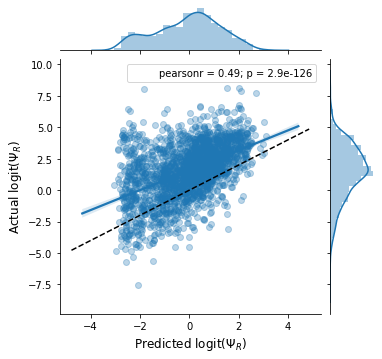

In [28]:
data_spliceai_postcas.plot_actual_vs_pred('spliceaiLogitAcceptor')
plt.savefig(os.path.join(IMAGES_DIR, 'spliceai_logit_post.png'), dpi=300, bbox_inches='tight')
plt.show()

### Fig 3B

Pearson's R 0.4956182096493141
Mean Squared Error 0.1290478694965629
Mean Absolute Error 0.2858691118944626
Median Absolute Error 0.23100540260836244
RMSE 0.35923233359006385
(0.4956182096493141, 2.1365317615414026e-131)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


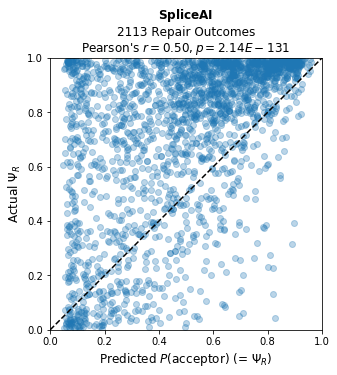

In [29]:
data_spliceai_postcas.plot_actual_vs_pred_simple('spliceaiLogitAcceptor', 'SpliceAI', 'spliceai_simple_post.png')
plt.show()

### PreCas SpliceAI Acceptor Prediction

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


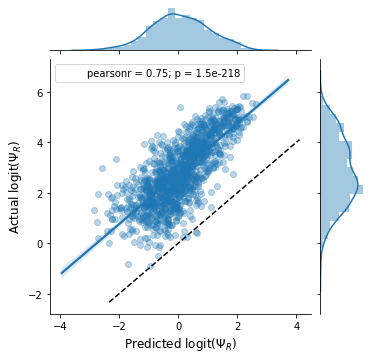

In [30]:
data_spliceai_precas.plot_actual_vs_pred('spliceaiLogitAcceptor')
plt.savefig(os.path.join(IMAGES_DIR, 'spliceai_logit_pre.png'), dpi=300, bbox_inches='tight')
plt.show()

### S4 FigB

Pearson's R 0.6001065885715342
Mean Squared Error 0.17908301077919003
Mean Absolute Error 0.3899570636535169
Median Absolute Error 0.38429118699104353
RMSE 0.4231820066817468
(0.6001065885715342, 8.869266123728846e-119)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


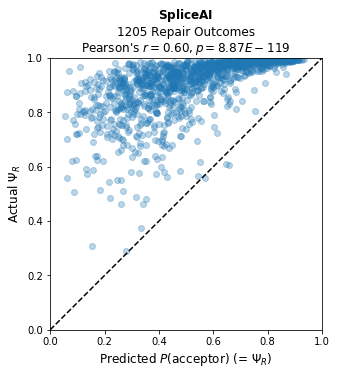

In [31]:
data_spliceai_precas.plot_actual_vs_pred_simple('spliceaiLogitAcceptor', 'SpliceAI', 'spliceai_pre.png')
plt.show()

### PostCas9 MMSplice Intron Prediction

### S3 FigA

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


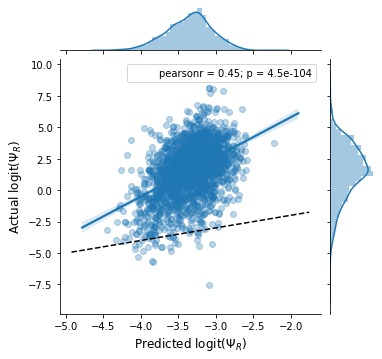

In [32]:
data_mmsplice_postcas.plot_actual_vs_pred('acceptorIntronScore')
plt.savefig(os.path.join(IMAGES_DIR, 'mmsplice_post_intron.png'), dpi=300, bbox_inches='tight')
plt.show()

### PreCas9 MMSplice Intron Prediction

### S4 FigC

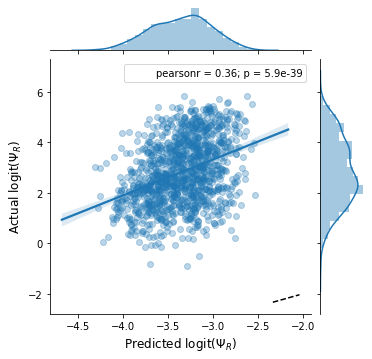

In [33]:
data_mmsplice_precas.plot_actual_vs_pred('acceptorIntronScore')
plt.savefig(os.path.join(IMAGES_DIR, 'mmsplice_pre_intron.png'), dpi=300, bbox_inches='tight')
plt.show()

### PostCas9 MMSplice Acceptor Prediction

### S3 FigB

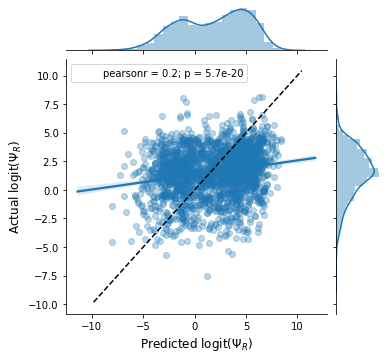

In [34]:
data_mmsplice_postcas.plot_actual_vs_pred('acceptorScore')
plt.savefig(os.path.join(IMAGES_DIR, 'mmsplice_post_acceptor.png'), dpi=300, bbox_inches='tight')
plt.show()

### PreCas9 MMSplice Acceptor Prediction

### S4 FigD

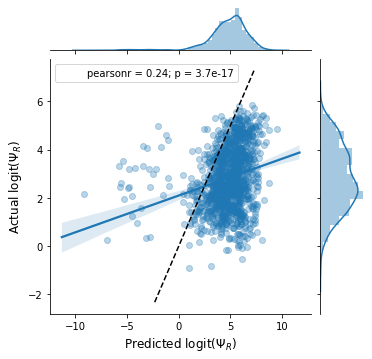

In [35]:
data_mmsplice_precas.plot_actual_vs_pred('acceptorScore')
plt.savefig(os.path.join(IMAGES_DIR, 'mmsplice_pre_acceptor.png'), dpi=300, bbox_inches='tight')
plt.show()

### PostCas9 MMSplice Exon Prediction

### S3 FigC

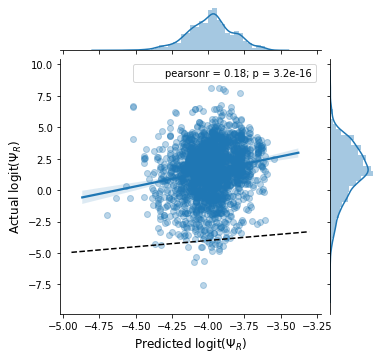

In [36]:
data_mmsplice_postcas.plot_actual_vs_pred('exonScore')
plt.savefig(os.path.join(IMAGES_DIR, 'mmsplice_post_exon.png'), dpi=300, bbox_inches='tight')
plt.show()

### PreCas9 MMSplice Exon Prediction

### S4 FigE

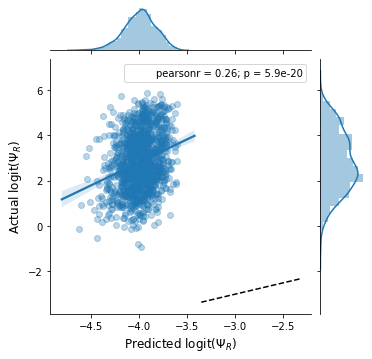

In [37]:
data_mmsplice_precas.plot_actual_vs_pred('exonScore')
plt.savefig(os.path.join(IMAGES_DIR, 'mmsplice_pre_exon.png'), dpi=300, bbox_inches='tight')
plt.show()

# MetaSplice and SkipGuide

In [38]:
gid_spliceai_repair_preds = load_var(SPLICEAI_GT_REPAIR_PREDS)
gid_spliceai_repair_preds = {gid: [logit(gid_spliceai_repair_preds[gid][0]).reshape(-1, 1),
                                   gid_spliceai_repair_preds[gid][1]]
                                   for gid in gid_spliceai_repair_preds}

In [39]:
def generate_gid_mmsplice_repair_preds():
    gid_mmsplice_repair_preds = {}
    for gid in tqdm(exp_gid_tid_map):
        gt = gid_to_gt(gid)
        cutsite = get_cutsite(*gt)
        indel_splice_count_map = collections.defaultdict(lambda: collections.defaultdict(int))
        distribution = predicted_gt_indel_dist_map[gt]
        for deletion_size in range(1, MAX_INDEL_LEN + 1):
            for genotype_pos in distribution[-deletion_size]:
                if distribution[-deletion_size][genotype_pos] > 0:
                    indel = ('', 'DS', deletion_size, genotype_pos, cutsite)
                    indel_splice_count_map[indel]['gid'] = gid
                    indel_splice_count_map[indel]['indelphifreq'] = distribution[-deletion_size][genotype_pos]
        for base in 'AGTC':
            if distribution[1][base] > 0:
                indel = ('', 'IS', 1, base, cutsite)
                indel_splice_count_map[indel]['gid'] = gid
                indel_splice_count_map[indel]['indelphifreq'] = distribution[1][base]

        postcas_csv = os.path.join(MMSPLICE_GT_DF_DIR, str(gid) + '.csv')
        mmsplice_df = pd.read_csv(postcas_csv)
        indelphifreq = [indel_splice_count_map[indel]['indelphifreq'] for indel, _ in indel_iterator(indel_splice_count_map)]
        
        X = mmsplice_df_to_scores_df(mmsplice_df, indel_splice_count_map, progress=False)
        gid_mmsplice_repair_preds[gid] = [X.tolist(), indelphifreq]
    return gid_mmsplice_repair_preds

In [40]:
if not pickle_exists(MMSPLICE_GT_REPAIR_PREDS):
    gid_mmsplice_repair_preds = generate_gid_mmsplice_repair_preds()
    save_var(gid_mmsplice_repair_preds, MMSPLICE_GT_REPAIR_PREDS)
else:
    gid_mmsplice_repair_preds = load_var(MMSPLICE_GT_REPAIR_PREDS)

gid_mmsplice_repair_preds = {gid: [np.array(gid_mmsplice_repair_preds[gid][0]),
                                   gid_mmsplice_repair_preds[gid][1]]
                                   for gid in gid_mmsplice_repair_preds}

In [41]:
def merge_gid_repair_preds(gid_repair_preds1, gid_repair_preds2):
    gid_repair_preds = {}
    for gid in gid_repair_preds1:
        gid_repair_preds[gid] = [np.hstack((gid_repair_preds1[gid][0], gid_repair_preds2[gid][0])),
                                 gid_repair_preds1[gid][1]]
    return gid_repair_preds

In [42]:
gid_all_repair_preds = merge_gid_repair_preds(gid_mmsplice_repair_preds, gid_spliceai_repair_preds)

In [43]:
# Inspired by https://stackoverflow.com/a/54254277
class RandomGroupKFold:
    def __init__(self, n_splits=5, random_state=None):
        self.n_splits = n_splits
        self.random_state = random_state
        
    def split(self, X, y, groups):
        groups = pd.Series(groups)
        ix = np.arange(len(groups))
        unique = np.unique(groups)
        np.random.RandomState(self.random_state).shuffle(unique)
        for split in np.array_split(unique, self.n_splits):
            mask = groups.isin(split)
            train, test = ix[~mask], ix[mask]
            yield (train, test)

In [44]:
class CVTrainEval:
    def __init__(self, name, data_precas, data_postcas, gid_repair_preds, gt_splice_count_map,
                 ablate_indelphi=False, ablate_metasplice=False):
        self.data_precas = data_precas
        self.data_postcas = data_postcas
        self.gid_repair_preds = gid_repair_preds
        self.gid_gt_idx_postcas_map = {exp_grna_gid_map[gt[0]][0]:(gt, i)
                                       for i, gt in enumerate(gt_splice_count_map.keys())}
        self.ablate_indelphi=ablate_indelphi
        self.ablate_metasplice=ablate_metasplice
        self.method = name
        
    def _cross_val_predict(self, k, groups, scorers, random_state=42):
        X = self.data_postcas.X_df
        y = self.data_postcas.y
        gids = self.data_postcas.gids
        
        self.y_lm_preds = []
        self.y_lm_actual = []
        self.y_lm_gids = []
        
        self.y_gt_preds = []
        self.y_gt_actual = []
        self.y_gt_gids = []
        
        self.y_gt_fold_preds = []
        self.y_gt_fold_actual = []
        self.y_gt_fold_gids = []
        
        scores = { 'metasplice': { name: [] for name,_ in scorers },
                   'skipguide': { name: [] for name,_ in scorers } }
        
        for train_index, test_index in groups.split(X, y, gids):
            X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values            
            y_train, y_test = y[train_index], y[test_index]
            gids_test = gids[test_index]
            gids_train = gids[train_index]
            
            # Picked alpha via RidgeCV below (currently commented out)
            model = Ridge(alpha=0.35, random_state=42)
#             alphas = [0.001, 0.01] + list(np.arange(0.1, 1, 0.05)) + [5, 10, 50, 100]
#             model = RidgeCV(alphas=alphas)
            model.fit(X_train, y_train)
#             print(model.alpha_)
            lm_preds = model.predict(X_test)
            self.y_lm_preds.extend(list(lm_preds))
            self.y_lm_actual.extend(list(y_test))
            self.y_lm_gids.extend(list(gids_test))
            
            for name, scorer in scorers:
                scores['metasplice'][name].append(scorer(expit(y_test), expit(lm_preds)))
            
            y_gt_fold_preds = []
            y_gt_fold_actual = []
            y_gt_fold_gids = []
            for gid in set(gids_test):
                gt_preds, indelphifreqs = self.gid_repair_preds[gid]
                if self.ablate_indelphi:
                    # Uniform weights instead of indelphi frequency weights
                    indelphifreqs = None
                    
                gt_preds = np.array(gt_preds)
                gt_pred = expit(model.predict(gt_preds))
    
                if self.ablate_metasplice:
                    if self.ablate_metasplice == 'random':
                        np.random.seed(random_state)
                        gt_pred = np.random.random_sample(len(gt_pred))
                    else:
                        gt_pred = self.ablate_metasplice * np.ones(len(gt_pred))
    
                y_gt_fold_preds.append(np.average(gt_pred, weights=indelphifreqs))
                idx = self.gid_gt_idx_postcas_map[gid][1]
                y_gt_fold_actual.append(aggBf_scores[idx])
                y_gt_fold_gids.append(gid)

            self.y_gt_preds.extend(y_gt_fold_preds)
            self.y_gt_actual.extend(y_gt_fold_actual)
            self.y_gt_gids.extend(y_gt_fold_gids)
            
            self.y_gt_fold_preds.append(y_gt_fold_preds)
            self.y_gt_fold_actual.append(y_gt_fold_actual)
            self.y_gt_fold_gids.append(y_gt_fold_gids)
                
            for name, scorer in scorers:
                scores['skipguide'][name].append(scorer(y_gt_fold_actual, y_gt_fold_preds))
        
        self.y_lm_preds = np.array(self.y_lm_preds)
        self.y_lm_actual = np.array(self.y_lm_actual)
        self.y_lm_gids = np.array(self.y_lm_gids)
        
        self.y_gt_preds = np.array(self.y_gt_preds)
        self.y_gt_actual = np.array(self.y_gt_actual)
        self.y_gt_gids = np.array(self.y_gt_gids)
        
        return scores

    
    def cross_val_predict(self, k=10, scorers=None, random_state=42):
        groups = GroupKFold(n_splits=k)
        return self._cross_val_predict(k, groups, scorers, random_state)
            
    def multi_kCV(self, k=10, scorers=None, num_trials=1):
        scores = { 'metasplice': { name: [] for name,_ in scorers },
                   'skipguide': { name: [] for name,_ in scorers } }
        for trial in tqdm(range(num_trials)):
            groups = RandomGroupKFold(n_splits=k, random_state=trial)
            scores_cv = self._cross_val_predict(k, groups, scorers)
            for name in scores_cv['metasplice']:
                scores['metasplice'][name].extend(scores_cv['metasplice'][name])
            for name in scores_cv['skipguide']:
                scores['skipguide'][name].extend(scores_cv['skipguide'][name])
        return scores

    def print_scores(self, scores):
        print('MetaSplice CV:')
        for name in scores['metasplice']:
            print(name, "{:.2f}".format(np.mean(scores['metasplice'][name])), "{:.2f}".format(np.std(scores['metasplice'][name])))
        print()
        print('SkipGuide CV:')
        for name in scores['skipguide']:
            print(name, "{:.2f}".format(np.mean(scores['skipguide'][name])), "{:.2f}".format(np.std(scores['skipguide'][name])))
            

    def plot_lm_logit(self, fname='wmmsplice_logit.png'):
        x = self.y_lm_preds
        y = self.y_lm_actual
        
        fig = plt.figure(figsize=(5,5))
        print(scipy.stats.pearsonr(x, y))
        plt.scatter(x, y, alpha=0.3)
        limx, limy = -8, 9
        plt.xlim((limx, limy))
        plt.ylim((limx, limy))
        plt.plot([limx, limy], [limx, limy], color='black', linestyle='dashed')
        plt.title(str(len(x)) + " Repair Outcomes Post Cas9\nPearson's $r = " +
                  "{:.2f}".format(scipy.stats.pearsonr(x, y)[0], 2) +
                  ', p = '+"{:.2E}".format(scipy.stats.pearsonr(x, y)[1]) +
                  '$', fontsize=12)
        plt.xlabel("Predicted logit($\Psi_R$)", fontsize=12)
        plt.ylabel("Actual logit($\Psi_R$)", fontsize=12)
        plt.axes().set_aspect('equal')
        plt.savefig(os.path.join(IMAGES_DIR, fname), dpi=300, bbox_inches='tight')
        plt.show()

    def plot_lm_interpretable(self, fname='wmmsplice_pred.png'):
        x = expit(self.y_lm_preds)
        y = expit(self.y_lm_actual)
        
        fig = plt.figure(figsize=(5,5))
        print(scipy.stats.pearsonr(x, y))
        plt.scatter(x, y, alpha=0.3)
        limx, limy = 0, 1
        plt.xlim((limx, limy))
        plt.ylim((limx, limy))
        plt.plot([limx, limy], [limx, limy], color='black', linestyle='dashed')
        plt.title("$\mathbf{" + self.method + "}$\n" + str(len(x)) + 
                  " Repair Outcomes\nPearson's $r = " +
                  "{:.2f}".format(scipy.stats.pearsonr(x, y)[0], 2) + 
                  ', p = '+"{:.2E}".format(scipy.stats.pearsonr(x, y)[1]) +
                  '$')
        plt.xlabel("Predicted $\Psi_R$", fontsize=12)
        plt.ylabel("Actual $\Psi_R$", fontsize=12)
        plt.axes().set_aspect('equal')
        plt.savefig(os.path.join(IMAGES_DIR, fname), dpi=300, bbox_inches='tight')
        plt.show()
        
    def plot_normal(self, fname='skipguide_preds.png'):
        fig = plt.figure(figsize=(5,5))
        plt.axes().set_aspect('equal')
        
        gids = self.y_gt_gids
        x, y = self.y_gt_preds, self.y_gt_actual
        print(scipy.stats.pearsonr(y, x))
        print(len(x), len(y))
        indel_splice_precas_count_map_list = list(indel_iterator(indel_splice_precas_count_map))
        precas_gid_bf = {count_map['gid']:splice_precas_Bf[i] 
                         for i, (indel, count_map) in enumerate(indel_splice_precas_count_map_list)}
        exclude_gid = set(gids) - precas_gid_bf.keys()
        x_inc = [x[i] for i, gid in enumerate(gids) if gid not in exclude_gid]
        x_ex = [x[i] for i, gid in enumerate(gids) if gid in exclude_gid]
        y_inc = [y[i] for i, gid in enumerate(gids) if gid not in exclude_gid]
        y_ex = [y[i] for i, gid in enumerate(gids) if gid in exclude_gid]
        actual_gids = [precas_gid_bf[gid] for gid in gids if gid not in exclude_gid]
        colors = actual_gids
        print(len(x_inc), len(x_ex))

        plt.scatter(x_inc, y_inc, c=colors, cmap=plt.cm.seismic, vmin=0, vmax=1, alpha=0.6)
        plt.axhline(0.5, color='gray', linestyle='dotted')
        plt.axvline(0.3, color='gray', linestyle='dotted')
        plt.text(0.02, 0.45, 'TP', color='0.25', weight='bold')
        plt.text(0.32, 0.45, 'FN', color='0.25', weight='bold')
        plt.text(0.02, 0.95, 'FP', color='0.25', weight='bold')
        plt.text(0.32, 0.95, 'TN', color='0.25', weight='bold')
        plt.colorbar(fraction=0.046, pad=0.04, label='$\Psi$ of WT lib-SA target (no Cas9)')
        plt.scatter(x_ex, y_ex, color='gray', marker='p', alpha=0.6)
        plt.xlim((0,1))
        plt.ylim((0,1))
        plt.plot([0,1], [0,1], linestyle='dashed', color='black')
        plt.title(str(len(x)) + " gRNAs\nPearson's $r = " +
                  "{:.2f}".format(scipy.stats.pearsonr(x,y)[0], 2) +
                  ', p = '+"{:.2E}".format(scipy.stats.pearsonr(x,y)[1]) +
                  '$')
        plt.xlabel("Predicted $\Psi_G$ (with Cas9)", fontsize=12)
        plt.ylabel("Actual $\Psi_G$ (with Cas9)", fontsize=12)
        plt.savefig(os.path.join(IMAGES_DIR, fname), dpi=300, bbox_inches='tight')
        plt.show()
        
    def plot_precision_recall(self, fname='precision_recall.png'):
        fig = plt.figure(figsize=(5,5))
        pf, yf = self.y_gt_preds, self.y_gt_actual
        ts = [min(pf), 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        precision = []
        recall = []
        for thres in ts:
            pb, yb = pf <= thres, yf <= 0.5
            s = precision_score(yb, pb)
            precision.append(s)
            recall.append(recall_score(yb, pb))
        plt.xlim((0,1))
        plt.ylim((0, 1.01))
        plt.title('Precision vs. Recall\nat various $\Psi_G$ Prediction Threshold')
        plt.xlabel("Recall", fontsize=12)
        plt.ylabel("Precision", fontsize=12)
        plt.plot(recall, precision, 'o-', color='black', zorder=1)
        plt.plot((0, recall[2]), (precision[2], precision[2]), color='gray', linestyle='dotted')
        plt.plot((recall[2], recall[2]), (0, precision[2]), color='gray', linestyle='dotted')
        plt.scatter(recall[2], precision[2], color='gray', zorder=3)
        plt.text(recall[2] + 0.04, precision[2] - 0.01, 
                 '$\Psi_G$ Threshold: 0.3\n Precision: ' + "{:.2f}".format(precision[2],2) + '; Recall: ' + "{:.2f}".format(recall[2],2))

        plt.plot((0, recall[4]), (precision[4], precision[4]), color='gray', linestyle='dotted')
        plt.plot((recall[4], recall[4]), (0, precision[4]), color='gray', linestyle='dotted')
        plt.scatter(recall[4], precision[4], color='gray', zorder=3)
        plt.text(recall[4] + 0.02, precision[4], 
                 '$\Psi_G$ Threshold: 0.5\n Precision: ' + "{:.2f}".format(precision[4],2) + '; Recall: ' + "{:.2f}".format(recall[4],2))
        plt.savefig(os.path.join(IMAGES_DIR, fname), dpi=300, bbox_inches='tight')
        plt.show()
        
    def plot_roc_auc(self, fname='roc.png'):
        fig, ax = plt.subplots(figsize=(5,5))
        tprs = []
        mean_fpr = np.linspace(0, 1, 100)
        aucs = []
        for i, (y, y_preds) in enumerate(zip(self.y_gt_fold_actual, self.y_gt_fold_preds)):
            y, y_preds = (np.array(y) <= 0.5).astype(int), 1 - np.array(y_preds)
            fpr, tpr, thresholds = roc_curve(y, y_preds, pos_label=1,
                                sample_weight=None,
                                drop_intermediate=True)
            
            roc_auc = auc(fpr, tpr)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(roc_auc)
            name = 'Fold {}'.format(i)
            
            line_kwargs = {'alpha':0.3, 'lw':1}
            line_kwargs["label"] = f"{name} (AUC = {roc_auc:0.2f})"
            limx, limy = 0, 1
            ax.set_xlim((limx, limy))
            ax.set_ylim((limx, limy))

            line_ = ax.plot(fpr, tpr, **line_kwargs)[0]
            
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='black',
                label=r'Mean AUC = %0.2f $\pm$ %0.2f' % (mean_auc, std_auc),
                lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
        
        ax.plot([0, 1], [0, 1], color='black', linestyle='dashed', alpha=.8)
        ax.set_xlabel("False Positive Rate", fontsize=12)
        ax.set_ylabel("True Positive Rate", fontsize=12)
        ax.set_title('ROC Curve and AUC\n(Actual $\Psi_G$ binarized with a threshold of 0.5)')

        if "label" in line_kwargs:
            ax.legend(loc='lower right')
            
        plt.savefig(os.path.join(IMAGES_DIR, fname), dpi=300, bbox_inches='tight')
        plt.show()
            
    def plot_precision_recall_curve(self, fname="precision_recall.png", dx3=0, dy3=0, dx5=0, dy5=0):
        fig, ax = plt.subplots(figsize=(5,5))

        for i, (y, y_preds) in enumerate(zip(self.y_gt_fold_actual, self.y_gt_fold_preds)):
            y, y_preds = (np.array(y) <= 0.5).astype(int), 1 - np.array(y_preds)
            precision, recall, thresholds = precision_recall_curve(y, y_preds, pos_label=1)

            name = 'Fold {}'.format(i)
            
            line_kwargs = {'alpha':0.3, 'lw':1}
            limx, limy = 0, 1
            ax.set_xlim((limx, limy))
            ax.set_ylim((limx, limy))

            line_ = ax.plot(recall, precision, **line_kwargs)[0]
        
        all_y, all_preds = (np.array(self.y_gt_actual) <= 0.5).astype(int), 1 - np.array(self.y_gt_preds)
        overall_precision, overall_recall, overall_thresholds = precision_recall_curve(all_y, all_preds)
        
        AP = average_precision_score(all_y, all_preds)
        ax.plot(overall_recall, overall_precision, color='black',
                label="Overall (Average Precision = {:.2f})".format(AP),
                lw=2, alpha=.8)
        
        for t in [0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9]:
            r = np.interp(1 - t, overall_thresholds, overall_recall[0:-1])
            p = np.interp(1 - t, overall_thresholds, overall_precision[0:-1])
            ax.scatter(r, p, s=60, facecolors='white', edgecolors='black', linewidths=2, zorder=3,
                      label= ('$\Psi_G$ Prediction Threshold \nfrom 0.1 to 0.9 at 0.1 increments' if t == 0.9 else None))
        
        p_thres_3 = np.interp(0.7, overall_thresholds, overall_precision[0:-1])
        r_thres_3 = np.interp(0.7, overall_thresholds, overall_recall[0:-1])
        p_thres_5 = np.interp(0.5, overall_thresholds, overall_precision[0:-1])
        r_thres_5 = np.interp(0.5, overall_thresholds, overall_recall[0:-1])
        
        ax.plot((0, r_thres_3), (p_thres_3, p_thres_3), color='gray', linewidth=2, linestyle='dotted')
        ax.plot((r_thres_3, r_thres_3), (0, p_thres_3), color='gray', linewidth=2, linestyle='dotted')
        ax.scatter(r_thres_3, p_thres_3, s=60, facecolors='lightgray', edgecolors='black', linewidths=2, zorder=3)
        ax.text(r_thres_3 + 0.05 + dx3, p_thres_3 - 0.03 + dy3, 
                 '$\Psi_G$ Threshold: 0.3\n Precision: ' + "{:.2f}".format(p_thres_3,2) + '; Recall: ' + "{:.2f}".format(r_thres_3,2))

        ax.plot((0, r_thres_5), (p_thres_5, p_thres_5), color='gray', linewidth=2, linestyle='dotted')
        ax.plot((r_thres_5, r_thres_5), (0, p_thres_5), color='gray', linewidth=2, linestyle='dotted')
        ax.scatter(r_thres_5, p_thres_5, s=60, facecolors='lightgray', edgecolors='black', linewidths=2, zorder=3)
        ax.text(r_thres_5 + 0.05 + dx5, p_thres_5 + dy5, 
                 '$\Psi_G$ Threshold: 0.5\n Precision: ' + "{:.2f}".format(p_thres_5,2) + '\n Recall: ' + "{:.2f}".format(r_thres_5,2))

        ax.set_xlabel("Recall", fontsize=12)
        ax.set_ylabel("Precision", fontsize=12)
        ax.set_title('Precision vs. Recall\nat various $\Psi_G$ Prediction Threshold')

        ax.legend()
        plt.savefig(os.path.join(IMAGES_DIR, fname), dpi=300, bbox_inches='tight')
        plt.show()

## MetaSplice using just MMSplice

In [45]:
cv_scorers=[("Pearson's R", lambda y,p: scipy.stats.pearsonr(y,p)[0]),
            ("Mean Squared Error", mean_squared_error),
            ("Mean Absolute Error", mean_absolute_error),
            ("Median Absolute Error", median_absolute_error),
            ("RMSE", lambda y,p: np.sqrt(mean_squared_error(y, p))),
            ("ROC AUC", lambda y,p: roc_auc_score(np.array(y)>0.5, p, average='macro')),
            ("Precision (0.3)", lambda y,p: precision_score(np.array(y)<=0.5, np.array(p)<=0.3)),
            ("Recall (0.3)", lambda y,p: recall_score(np.array(y)<=0.5, np.array(p)<=0.3))]

multi_cv_num_trials = 1000

In [46]:
cv_mmsplice_eval = CVTrainEval('wMMSplice', data_mmsplice_precas, data_mmsplice_postcas,
                               gid_mmsplice_repair_preds, gt_splice_count_map)

In [47]:
scores = cv_mmsplice_eval.multi_kCV(k=10, scorers=cv_scorers, num_trials=multi_cv_num_trials)
cv_mmsplice_eval.print_scores(scores)

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a


MetaSplice CV:
Pearson's R 0.54 0.07
Mean Squared Error 0.06 0.01
Mean Absolute Error 0.18 0.02
Median Absolute Error 0.11 0.02
RMSE 0.25 0.02
ROC AUC 0.79 0.04
Precision (0.3) 0.84 0.22
Recall (0.3) 0.09 0.05

SkipGuide CV:
Pearson's R 0.61 0.07
Mean Squared Error 0.05 0.01
Mean Absolute Error 0.17 0.01
Median Absolute Error 0.13 0.01
RMSE 0.23 0.02
ROC AUC 0.81 0.05
Precision (0.3) 0.87 0.25
Recall (0.3) 0.10 0.06


In [48]:
scores = cv_mmsplice_eval.cross_val_predict(k=10, scorers=cv_scorers)
cv_mmsplice_eval.print_scores(scores)

MetaSplice CV:
Pearson's R 0.55 0.06
Mean Squared Error 0.06 0.01
Mean Absolute Error 0.18 0.01
Median Absolute Error 0.11 0.01
RMSE 0.25 0.02
ROC AUC 0.79 0.03
Precision (0.3) 0.85 0.18
Recall (0.3) 0.09 0.05

SkipGuide CV:
Pearson's R 0.61 0.05
Mean Squared Error 0.05 0.01
Mean Absolute Error 0.17 0.02
Median Absolute Error 0.13 0.02
RMSE 0.23 0.02
ROC AUC 0.81 0.03
Precision (0.3) 0.91 0.16
Recall (0.3) 0.11 0.05


(0.5340794870701294, 3.776437906281803e-156)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:156: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


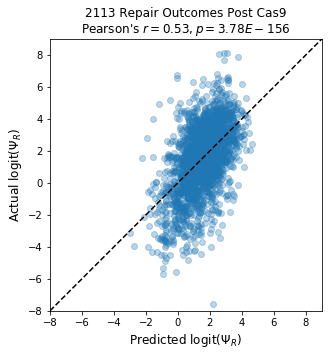

In [49]:
cv_mmsplice_eval.plot_lm_logit('meta_mmsplice_logit.png')

### Fig 3C

(0.5453891137632499, 4.6853822066178844e-164)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:178: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


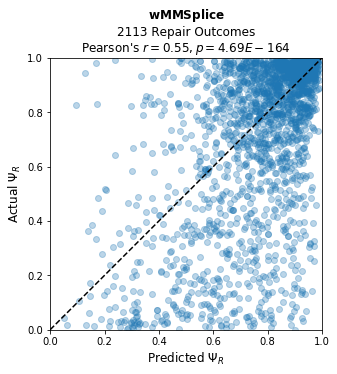

In [50]:
cv_mmsplice_eval.plot_lm_interpretable('meta_mmsplice_pred.png')

### S7 Fig A - C

(0.6099820693573289, 2.4654935033113986e-109)
1063 1063
735 328


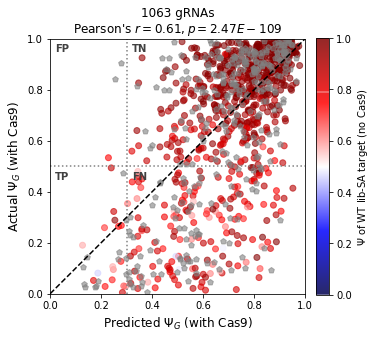

In [51]:
cv_mmsplice_eval.plot_normal('skipguide_mmsplice_preds.png')

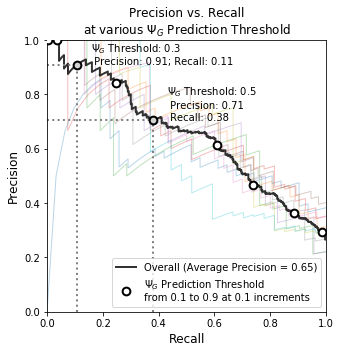

In [52]:
cv_mmsplice_eval.plot_precision_recall_curve('meta_mmsplice_pr.png', dx3=0, dy3=0.03, dx5=0, dy5=0)

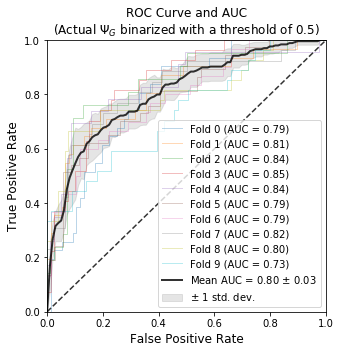

In [53]:
cv_mmsplice_eval.plot_roc_auc('meta_mmsplice_roc.png')

## MetaSplice using just SpliceAI

In [54]:
cv_spliceai_eval = CVTrainEval('wSpliceAI', data_spliceai_precas, data_spliceai_postcas,
                               gid_spliceai_repair_preds, gt_splice_count_map)

In [55]:
scores = cv_spliceai_eval.multi_kCV(k=10, scorers=cv_scorers, num_trials=multi_cv_num_trials)
cv_spliceai_eval.print_scores(scores)

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a


MetaSplice CV:
Pearson's R 0.46 0.07
Mean Squared Error 0.07 0.01
Mean Absolute Error 0.19 0.02
Median Absolute Error 0.11 0.02
RMSE 0.27 0.02
ROC AUC 0.78 0.04
Precision (0.3) 0.00 0.04
Recall (0.3) 0.00 0.00

SkipGuide CV:
Pearson's R 0.52 0.07
Mean Squared Error 0.06 0.01
Mean Absolute Error 0.20 0.01
Median Absolute Error 0.18 0.02
RMSE 0.25 0.01
ROC AUC 0.76 0.05
Precision (0.3) 0.00 0.00
Recall (0.3) 0.00 0.00


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [56]:
scores = cv_spliceai_eval.cross_val_predict(k=10, scorers=cv_scorers)
cv_spliceai_eval.print_scores(scores)

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

MetaSplice CV:
Pearson's R 0.46 0.07
Mean Squared Error 0.07 0.01
Mean Absolute Error 0.19 0.02
Median Absolute Error 0.11 0.02
RMSE 0.27 0.02
ROC AUC 0.78 0.03
Precision (0.3) 0.00 0.00
Recall (0.3) 0.00 0.00

SkipGuide CV:
Pearson's R 0.52 0.07
Mean Squared Error 0.06 0.01
Mean Absolute Error 0.20 0.01
Median Absolute Error 0.18 0.01
RMSE 0.25 0.01
ROC AUC 0.76 0.05
Precision (0.3) 0.00 0.00
Recall (0.3) 0.00 0.00


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:156: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(0.4856337154872375, 1.793239767963175e-125)


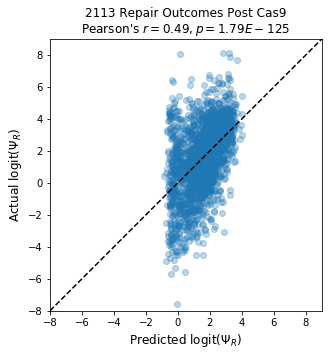

In [57]:
cv_spliceai_eval.plot_lm_logit('meta_spliceai_logit.png')

(0.46108984327706637, 1.0165276014617605e-111)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:178: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


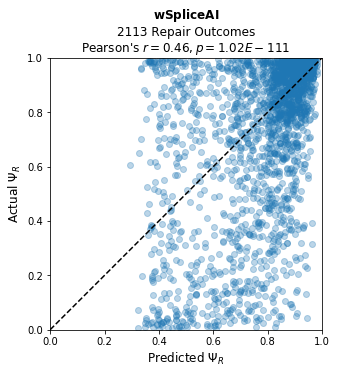

In [58]:
cv_spliceai_eval.plot_lm_interpretable('meta_spliceai_pred.png')

### S7 Fig D - F

(0.5237996741446519, 6.017400728229095e-76)
1063 1063
735 328


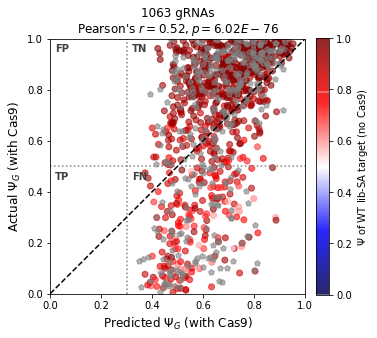

In [59]:
cv_spliceai_eval.plot_normal('skipguide_spliceai_preds.png')

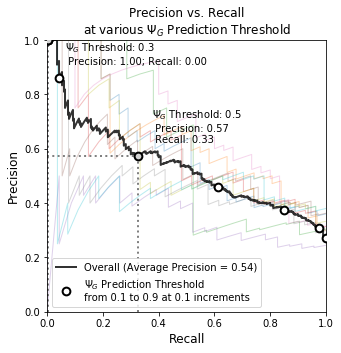

In [60]:
cv_spliceai_eval.plot_precision_recall_curve('meta_spliceai_pr.png', dx3=0.01, dy3=-0.06, dx5=0, dy5=0.05)

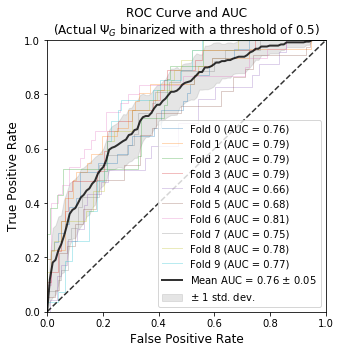

In [61]:
cv_spliceai_eval.plot_roc_auc('meta_spliceai_roc.png')

## MetaSplice using MMSplice + SpliceAI

In [62]:
cv_eval = CVTrainEval('MetaSplice', data_all_precas, data_all_postcas,
                      gid_all_repair_preds, gt_splice_count_map)

In [63]:
scores = cv_eval.multi_kCV(k=10, scorers=cv_scorers, num_trials=multi_cv_num_trials)
cv_eval.print_scores(scores)

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a


MetaSplice CV:
Pearson's R 0.62 0.06
Mean Squared Error 0.05 0.01
Mean Absolute Error 0.16 0.01
Median Absolute Error 0.10 0.01
RMSE 0.23 0.02
ROC AUC 0.84 0.04
Precision (0.3) 0.86 0.14
Recall (0.3) 0.12 0.05

SkipGuide CV:
Pearson's R 0.67 0.06
Mean Squared Error 0.05 0.01
Mean Absolute Error 0.17 0.01
Median Absolute Error 0.13 0.02
RMSE 0.21 0.01
ROC AUC 0.84 0.04
Precision (0.3) 0.94 0.12
Recall (0.3) 0.19 0.07


In [64]:
scores = cv_eval.cross_val_predict(k=10, scorers=cv_scorers)
cv_eval.print_scores(scores)

MetaSplice CV:
Pearson's R 0.62 0.05
Mean Squared Error 0.05 0.01
Mean Absolute Error 0.16 0.02
Median Absolute Error 0.11 0.02
RMSE 0.23 0.02
ROC AUC 0.84 0.03
Precision (0.3) 0.83 0.16
Recall (0.3) 0.13 0.06

SkipGuide CV:
Pearson's R 0.67 0.04
Mean Squared Error 0.05 0.01
Mean Absolute Error 0.17 0.01
Median Absolute Error 0.13 0.02
RMSE 0.21 0.01
ROC AUC 0.84 0.03
Precision (0.3) 0.94 0.07
Recall (0.3) 0.20 0.06


(0.6024350841944414, 6.030213314545273e-209)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:156: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


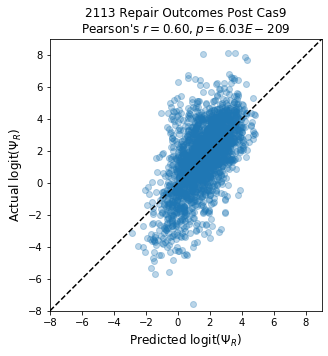

In [65]:
cv_eval.plot_lm_logit('metasplice_logit.png')

### Fig 3D

(0.6218640894361998, 2.1050718188747973e-226)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:178: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


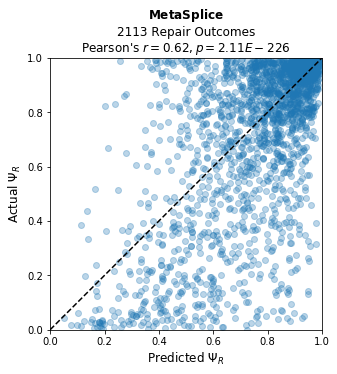

In [66]:
cv_eval.plot_lm_interpretable('metasplice_pred.png')

### Fig 4 A - C

(0.6707702714708141, 7.120017619117353e-140)
1063 1063
735 328


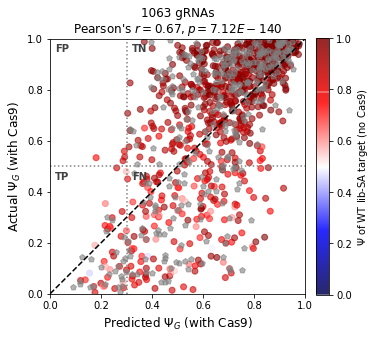

In [67]:
cv_eval.plot_normal('skipguide_metasplice_preds.png')

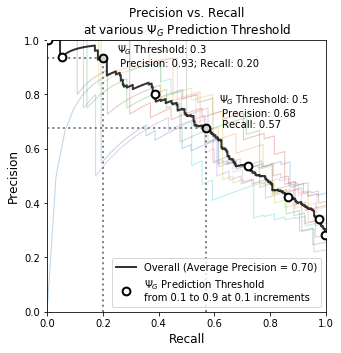

In [68]:
cv_eval.plot_precision_recall_curve('metasplice_pr.png')

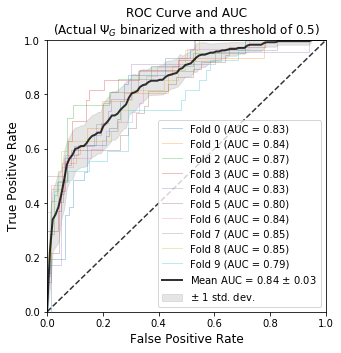

In [69]:
cv_eval.plot_roc_auc('metasplice_roc.png')

## S8 Fig (Perturbation Studies)

### Ablate inDelphi (Uniform Output: output $P(r)=1$ for all possible repairs r)

In [70]:
cv_eval_indelphi_uniform = CVTrainEval('', data_all_precas, data_all_postcas,
                      gid_all_repair_preds, gt_splice_count_map, ablate_indelphi=True)
scores = cv_eval_indelphi_uniform.cross_val_predict(k=10, scorers=cv_scorers)
cv_eval_indelphi_uniform.print_scores(scores)

MetaSplice CV:
Pearson's R 0.62 0.05
Mean Squared Error 0.05 0.01
Mean Absolute Error 0.16 0.02
Median Absolute Error 0.11 0.02
RMSE 0.23 0.02
ROC AUC 0.84 0.03
Precision (0.3) 0.83 0.16
Recall (0.3) 0.13 0.06

SkipGuide CV:
Pearson's R 0.57 0.04
Mean Squared Error 0.09 0.01
Mean Absolute Error 0.25 0.01
Median Absolute Error 0.25 0.02
RMSE 0.29 0.01
ROC AUC 0.80 0.04
Precision (0.3) 0.70 0.09
Recall (0.3) 0.37 0.07


(0.5707860022447571, 6.386126039809266e-93)
1063 1063
735 328


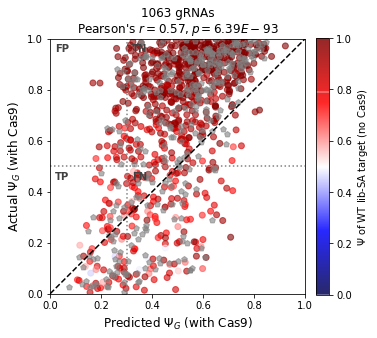

In [71]:
cv_eval_indelphi_uniform.plot_normal('ab_indelphi.png')

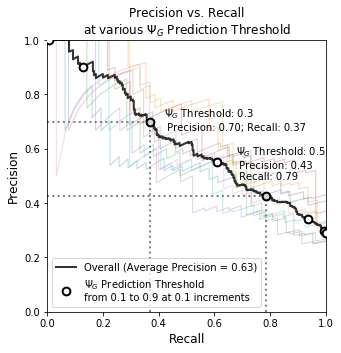

In [72]:
cv_eval_indelphi_uniform.plot_precision_recall_curve('ab_indelphi_pr.png', dx3=0, dy3=0, dx5=-0.16, dy5=0.06)

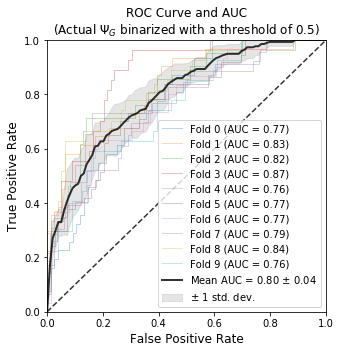

In [73]:
cv_eval_indelphi_uniform.plot_roc_auc('ab_indelphi_roc.png')

### Ablate MetaSplice (Ranom Output: output random $P(\Psi_R)$ between 0 and 1 for each repair genotype)

In [74]:
cv_eval_metasplice_random = CVTrainEval('', data_all_precas, data_all_postcas,
                      gid_all_repair_preds, gt_splice_count_map, ablate_indelphi=False, ablate_metasplice='random')
scores = cv_eval_metasplice_random.cross_val_predict(k=10, scorers=cv_scorers)
cv_eval_metasplice_random.print_scores(scores)

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

MetaSplice CV:
Pearson's R 0.62 0.05
Mean Squared Error 0.05 0.01
Mean Absolute Error 0.16 0.02
Median Absolute Error 0.11 0.02
RMSE 0.23 0.02
ROC AUC 0.84 0.03
Precision (0.3) 0.83 0.16
Recall (0.3) 0.13 0.06

SkipGuide CV:
Pearson's R 0.04 0.08
Mean Squared Error 0.12 0.00
Mean Absolute Error 0.31 0.01
Median Absolute Error 0.33 0.01
RMSE 0.35 0.01
ROC AUC 0.52 0.06
Precision (0.3) 0.05 0.15
Recall (0.3) 0.00 0.01


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.03210374723907367, 0.2956818390292377)
1063 1063
735 328


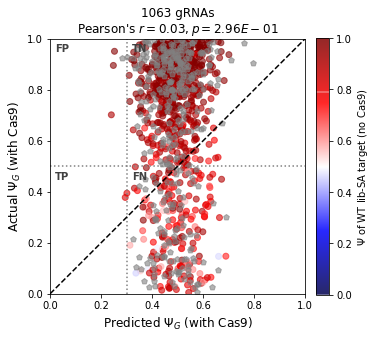

In [75]:
cv_eval_metasplice_random.plot_normal('ab_metasplice.png')

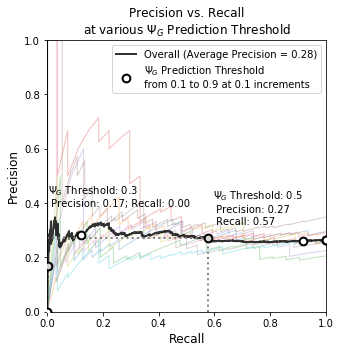

In [76]:
cv_eval_metasplice_random.plot_precision_recall_curve('ab_metasplice_pr.png', dx3=-0.05, dy3=0.25, dx5=-0.03, dy5=0.05)

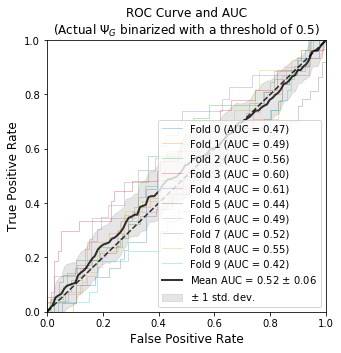

In [77]:
cv_eval_metasplice_random.plot_roc_auc('ab_metasplice_roc.png')

### Ablate MetaSplice (Constant Output: output $P(\Psi_R) = 1$ for each repair genotype)

In [78]:
cv_eval_metasplice_1 = CVTrainEval('', data_all_precas, data_all_postcas,
                      gid_all_repair_preds, gt_splice_count_map, ablate_indelphi=False, ablate_metasplice=1)
scores = cv_eval_metasplice_1.cross_val_predict(k=10, scorers=cv_scorers)
cv_eval_metasplice_1.print_scores(scores)

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/li

MetaSplice CV:
Pearson's R 0.62 0.05
Mean Squared Error 0.05 0.01
Mean Absolute Error 0.16 0.02
Median Absolute Error 0.11 0.02
RMSE 0.23 0.02
ROC AUC 0.84 0.03
Precision (0.3) 0.83 0.16
Recall (0.3) 0.13 0.06

SkipGuide CV:
Pearson's R nan nan
Mean Squared Error 0.19 0.02
Mean Absolute Error 0.33 0.03
Median Absolute Error 0.22 0.03
RMSE 0.43 0.03
ROC AUC 0.50 0.00
Precision (0.3) 0.00 0.00
Recall (0.3) 0.00 0.00


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


(nan, 1.0)
1063 1063
735 328


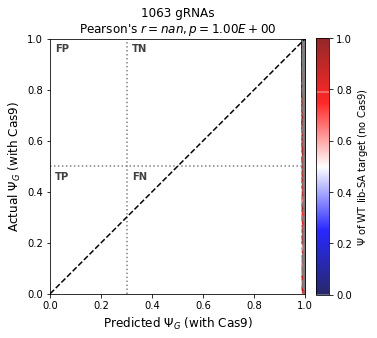

In [79]:
cv_eval_metasplice_1.plot_normal('ab_metasplice1.png')

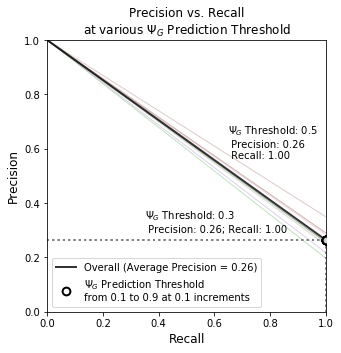

In [80]:
cv_eval_metasplice_1.plot_precision_recall_curve('ab_metasplice_pr1.png', dx3=-0.7, dy3=0.06, dx5=-0.4, dy5=0.3)

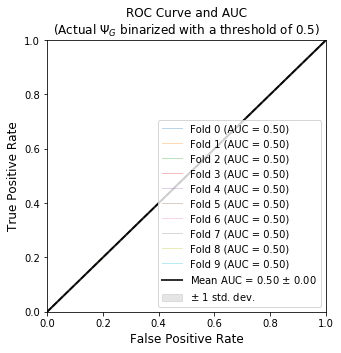

In [81]:
cv_eval_metasplice_1.plot_roc_auc('ab_metasplice_roc1.png')

### Ablate both inDephi (Uniform Output) and MetaSplice (Random Output)

In [82]:
cv_eval_ablated = CVTrainEval('', data_all_precas, data_all_postcas,
                      gid_all_repair_preds, gt_splice_count_map, ablate_indelphi=True, ablate_metasplice='random')
scores = cv_eval_ablated.cross_val_predict(k=10, scorers=cv_scorers, random_state=10)
cv_eval_ablated.print_scores(scores)

/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined a

MetaSplice CV:
Pearson's R 0.62 0.05
Mean Squared Error 0.05 0.01
Mean Absolute Error 0.16 0.02
Median Absolute Error 0.11 0.02
RMSE 0.23 0.02
ROC AUC 0.84 0.03
Precision (0.3) 0.83 0.16
Recall (0.3) 0.13 0.06

SkipGuide CV:
Pearson's R 0.03 0.10
Mean Squared Error 0.12 0.01
Mean Absolute Error 0.31 0.01
Median Absolute Error 0.34 0.01
RMSE 0.34 0.01
ROC AUC 0.51 0.06
Precision (0.3) 0.00 0.00
Recall (0.3) 0.00 0.00


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.032525190522696305, 0.28938415863769773)
1063 1063
735 328


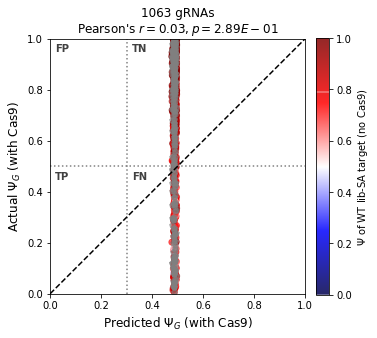

In [83]:
cv_eval_ablated.plot_normal('ab_both.png')

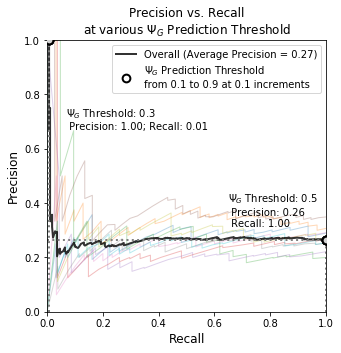

In [84]:
cv_eval_ablated.plot_precision_recall_curve('ab_both_pr.png', dx3=0.01, dy3=-0.3, dx5=-0.4, dy5=0.05)

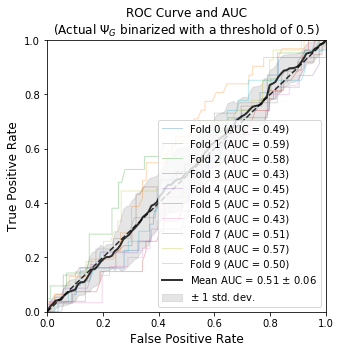

In [85]:
cv_eval_ablated.plot_roc_auc('ab_both_roc.png')

# Fit MetaSplice Model on all data

In [86]:
metasplice_model = Ridge(alpha=0.35, random_state=42)
metasplice_model.fit(data_all_postcas.X_df, data_all_postcas.y)

Ridge(alpha=0.35, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

In [87]:
# MMSplice intron score, MMSplice acceptor score, MMSplice exon score, SpliceAI score
metasplice_model.coef_

array([2.541426  , 0.0153251 , 2.86634866, 0.54322554])

In [88]:
metasplice_model.intercept_

21.487716750334044

In [89]:
save_var(metasplice_model, 'MetaSplice_model')

## S4 FigF

In [90]:
def plot_logit(y_preds, y_actual, fname='metasplice_pre_logit.png'):       
    fig = plt.figure(figsize=(5,5))
    print(scipy.stats.pearsonr(y_actual, y_preds))
    plt.scatter(y_preds, y_actual, alpha=0.3)
    limx, limy = -8, 9
    plt.xlim((limx, limy))
    plt.ylim((limx, limy))
    plt.plot([limx, limy], [limx, limy], color='black', linestyle='dashed')
    plt.title(str(len(y_preds)) + " Targets Pre Cas9\nPearson's $r = " +
              "{:.2f}".format(scipy.stats.pearsonr(y_actual, y_preds)[0], 2) +
              ', p = '+"{:.2E}".format(scipy.stats.pearsonr(y_actual, y_preds)[1]) +
              '$', fontsize=12)
    plt.xlabel("Predicted logit(WT $\Psi$)", fontsize=12)
    plt.ylabel("Actual logit(WT $\Psi$)", fontsize=12)
    plt.axes().set_aspect('equal')
    plt.savefig(os.path.join(IMAGES_DIR, fname), dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_interpretable(y_preds, y_actual, fname='metasplice_pre_pred.png'):
    y_preds = expit(np.array(y_preds))
    y_actual = expit(np.array(y_actual))
    fig = plt.figure(figsize=(5,5))
    print(scipy.stats.pearsonr(y_actual, y_preds))
    plt.scatter(y_preds, y_actual, alpha=0.3)
    limx, limy = 0, 1
    plt.xlim((limx, limy))
    plt.ylim((limx, limy))
    plt.plot([limx, limy], [limx, limy], color='black', linestyle='dashed')
    plt.title(str(len(y_preds)) + 
              " Targets Pre Cas9\nPearson's $r = " +
              "{:.2f}".format(scipy.stats.pearsonr(y_actual, y_preds)[0], 2) + 
              ', p = '+"{:.2E}".format(scipy.stats.pearsonr(y_actual, y_preds)[1]) +
              '$')
    plt.xlabel("Predicted WT $\Psi$", fontsize=12)
    plt.ylabel("Actual WT $\Psi$", fontsize=12)
    plt.axes().set_aspect('equal')
    plt.savefig(os.path.join(IMAGES_DIR, fname), dpi=300, bbox_inches='tight')
    plt.show()

(0.7007411684043541, 1.2216158074577372e-178)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


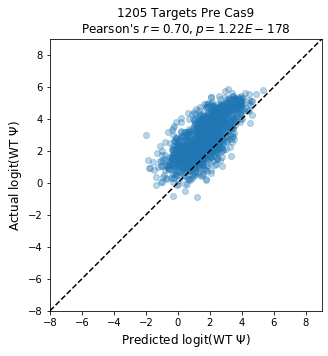

In [91]:
plot_logit(metasplice_model.predict(data_all_precas.X_df), data_all_precas.y)

(0.5832799114142124, 9.236979142623719e-111)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


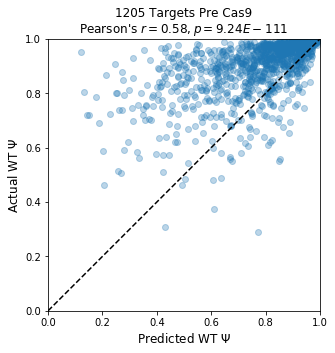

In [92]:
plot_interpretable(metasplice_model.predict(data_all_precas.X_df), data_all_precas.y)